# Skillbox — Мастер-класс: Разведочный анализ данных + Подготовка отчётов — Kiva.org
***

# 4. Домашнее задание

## 4.1. Самостоятельная работа

- А в каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)

In [180]:
import numpy as np
import pandas as pd
import math
import missingno as msno
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')

import os
df_kiva_loans = pd.read_csv("../kiva/kiva_loans.csv")
df_mpi = pd.read_csv("../kiva/kiva_mpi_region_locations.csv")
countries = df_kiva_loans['country'].value_counts()[df_kiva_loans['country'].value_counts(normalize=True)> 0.005]
list_countries = list(countries.index)
df_kiva_loans['borrower_genders'].value_counts()
df_kiva_loans['borrower_genders'] = [elem if elem in ['female','male'] else 'group' for elem in df_kiva_loans['borrower_genders']]

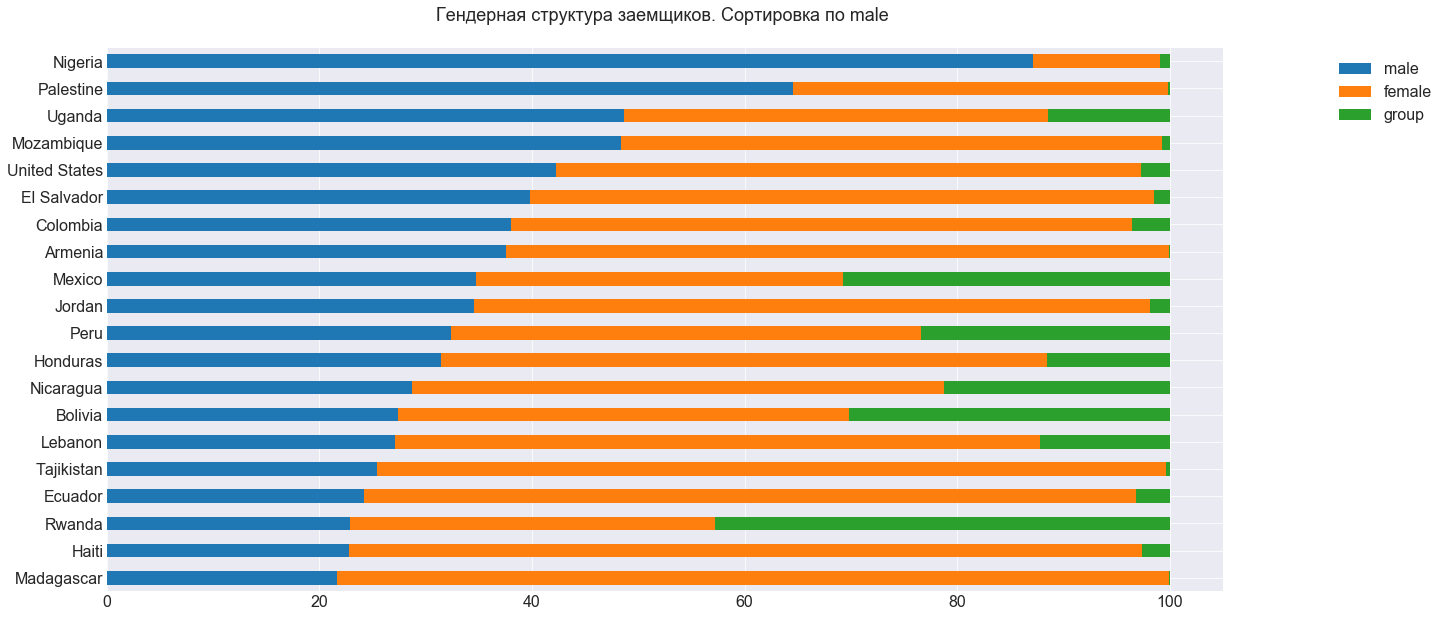

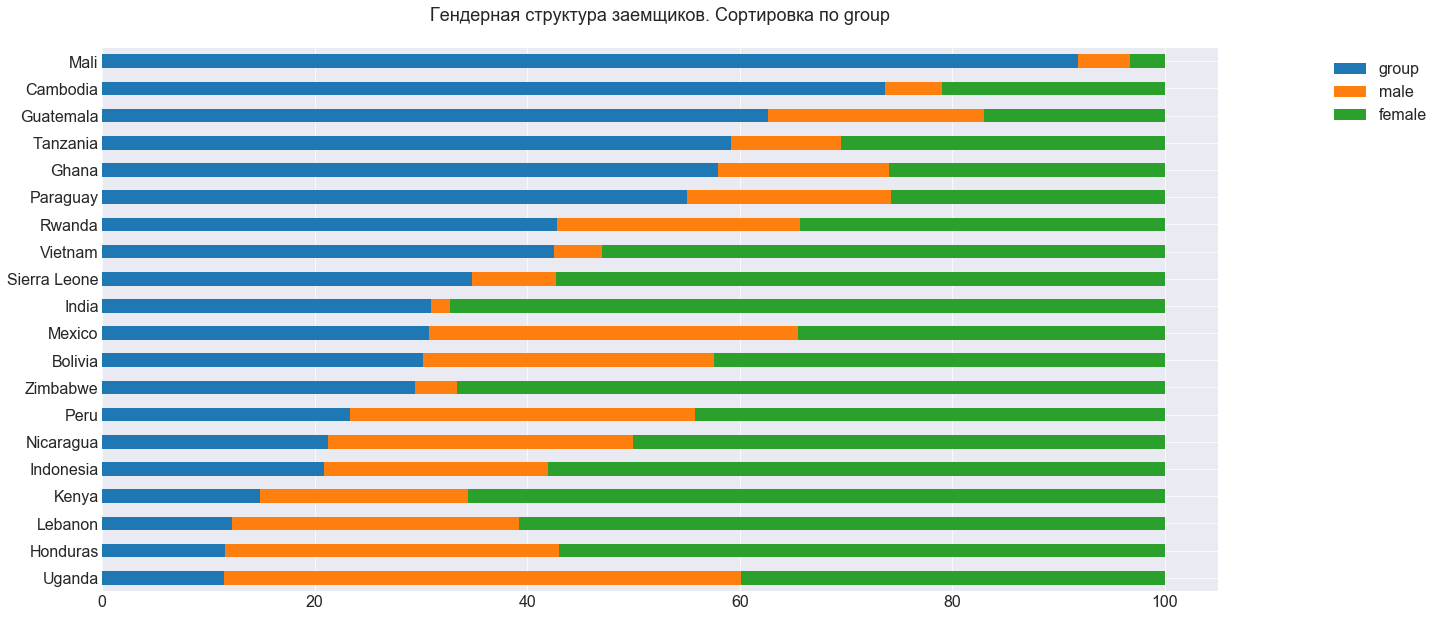

In [181]:
df_gender_by_country = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['male', 'female'])[-20:]

df_gender_by_country = df_gender_by_country[['male', 'female', 'group']]
plot = df_gender_by_country.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков. Сортировка по male \n')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()


df_gender_by_country = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['group'])[-20:]

df_gender_by_country = df_gender_by_country[['group', 'male', 'female']]
plot = df_gender_by_country.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков. Сортировка по group\n')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

In [182]:
print('\033[1m' + 'Мужчины преобладают в Нигерии, Палестине, Уганде')
print('Группы людей преобладают в Мали, Камбодже, Гватемале, Танзании, Гане, Парагвае')

Мужчины преобладают в Нигерии, Палестине, Уганде
Группы людей преобладают в Мали, Камбодже, Гватемале, Танзании, Гане, Парагвае


***

- Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей? (п. 2.4.2.)

In [183]:
df_kiva_loans.sort_values('loan_amount', ascending = False)[['loan_amount','country','use','borrower_genders']].head(10)

,loan_amount,country,use,borrower_genders
70499,100000.0,Haiti,create more than 300 jobs for women and farmer...,female
408465,50000.0,Peru,NaN,group
583307,50000.0,Guatemala,to support 800+ farmers by improving their pro...,male
126839,50000.0,Mexico,to buy and plant resin producing pine trees. T...,group
447374,50000.0,Uganda,to increase smallholder farmers’ incomes by bu...,male
210975,50000.0,Rwanda,To work with 17 farming cooperatives to proces...,male
53634,50000.0,Uganda,To buy and sell Barefoot Power solar lighting.,female
494470,50000.0,Kenya,To pay smallholder coffee farmers in rural Ken...,female
538248,50000.0,Kenya,"to enable 5,000 additional small-holder farmer...",male
660807,50000.0,Pakistan,to distribute 400 pay-as-you-go solar systems ...,female


In [184]:
print('\033[1m' + 'Займы с большими суммами (топ-10) как правило брали на развитие фермерства \nГендерный состав заявителей различный. \nПреобладающие страны из Африки')

Займы с большими суммами (топ-10) как правило брали на развитие фермерства 
Гендерный состав заявителей различный. 
Преобладающие страны из Африки


***

- Попробуйте найти связь между странами (регионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных? (п. 2.4.3.)

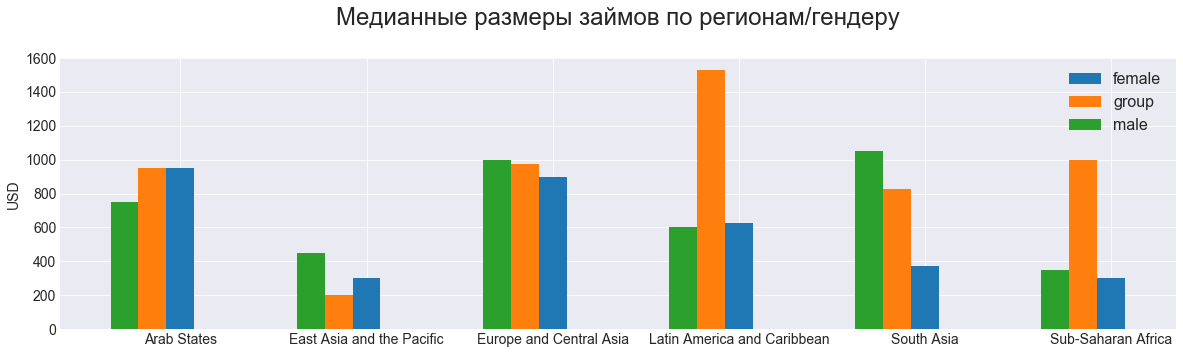

In [228]:
df_mpi_grouped = df_mpi\
    .groupby(['ISO', 'country', 'world_region'])['MPI']\
    .mean()\
    .fillna(0)\
    .reset_index()
temp = df_kiva_loans.merge(df_mpi_grouped, how='left', on='country').copy()
regions = temp['world_region'].value_counts()
regions_list = regions.index.to_list()
dev = (temp['loan_amount'] - temp['loan_amount'].mean()).abs()
std = temp['loan_amount'].std()
temp['borrower_genders'] = [elem if elem in ['female','male'] else 'group' for elem in temp['borrower_genders']]
df_kiva_loans_trimmed = temp[~(dev>3*std)]
plt.figure(figsize=(20, 5))
x = np.asarray([0, 1, 2, 3, 4, 5])
width = 0.15
i = 0
for name, group in df_kiva_loans_trimmed.groupby(['borrower_genders']):
    plt.bar(x - i*width, group.groupby('world_region').agg('median')['loan_amount'].values, width, label=name)
    i += 1

plt.title('Медианные размеры займов по регионам/гендеру\n',fontsize = 24)
plt.xticks(x, list(df_kiva_loans_trimmed.groupby('world_region').groups.keys()),fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('USD', fontsize = 14)
plt.legend(fontsize = 16)
plt.show()

In [188]:
print('\033[1m' + 'Наибольшие средние суммы займов выдавались группам лиц в странах Латинской Америки, \nнаименьшие средние суммы выдавались женщинам в странах Восточной Азии и Африке. \nМужчинам наибольшие суммы выдавали в Европе, Центральной и Южной Азии.')

Наибольшие средние суммы займов выдавались группам лиц в странах Латинской Америки, 
наименьшие средние суммы выдавались женщинам в странах Восточной Азии и Африке. 
Мужчинам наибольшие суммы выдавали в Европе, Центральной и Южной Азии.


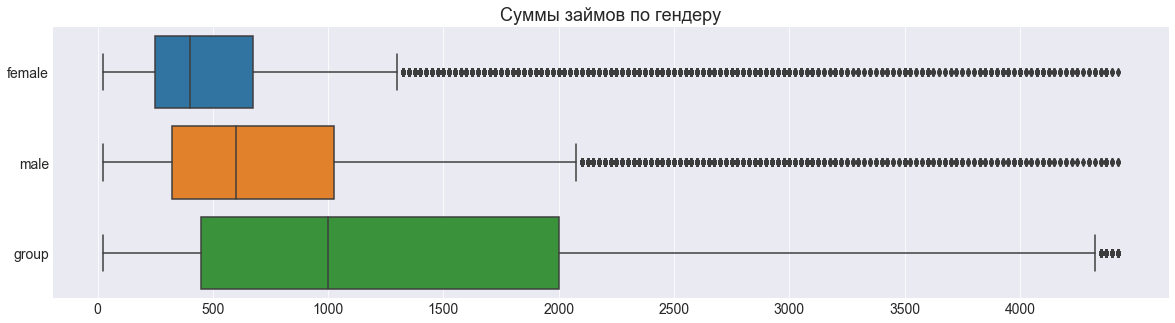

In [189]:
borrowers = temp['borrower_genders'].value_counts()
borrowers_list = borrowers.index.to_list()

plt.figure(figsize=(20,5))
plt.title("Суммы займов по гендеру", fontsize=18)
plt.xticks(np.arange(0, max(df_kiva_loans_trimmed['loan_amount']+1), 500))
plt.tick_params(labelsize=14)

sns.boxplot(x = 'loan_amount', y = "borrower_genders", order = borrowers_list, data = df_kiva_loans_trimmed)\
    .set(ylabel=None, xlabel=None)
plt.show()

## 4.2. Домашняя работа
***

- Зависимость пола заёмщика от региона планеты, сектора экономики.

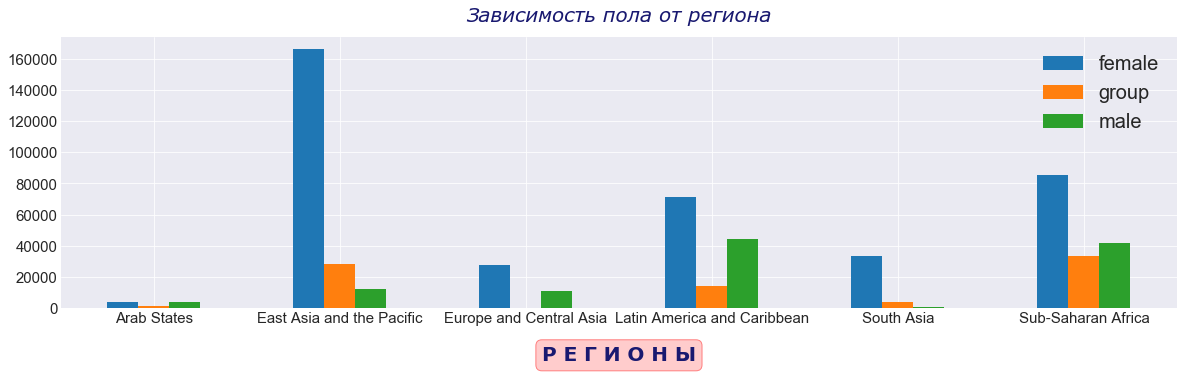

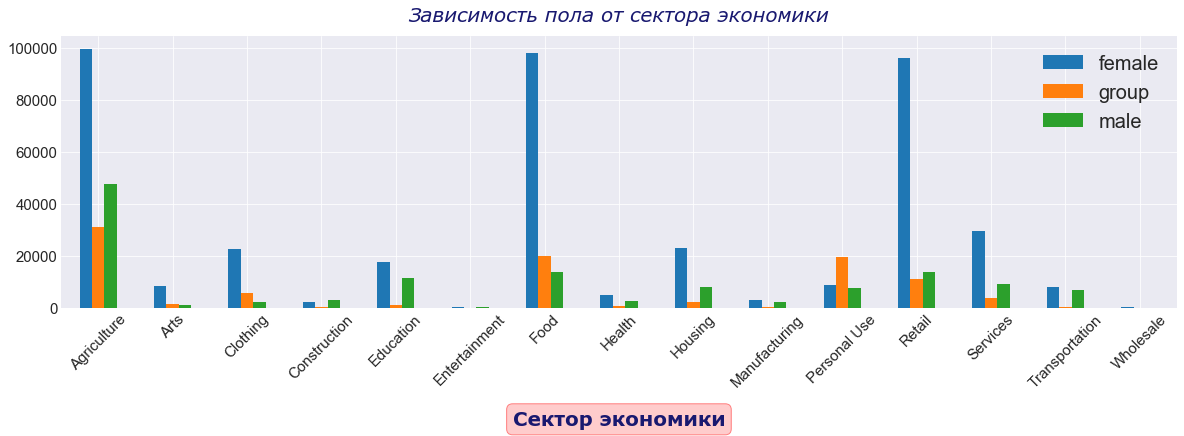

In [249]:
gender_vs_region = df_kiva_loans_trimmed[['world_region','borrower_genders', 'id']].dropna()
gender_vs_region = gender_vs_region.groupby(['world_region', 'borrower_genders']).count()
gender_vs_region.unstack(level=1).plot(kind='bar', rot=0, fontsize = 15, figsize=(20,5))
plt.legend(list(gender_vs_region.groupby('borrower_genders').groups.keys()), fontsize = 20)
plt.title('Зависимость пола от региона', pad = 15, fontsize = 20, fontstyle = 'oblique', color = 'midnightblue', fontfamily = 'Verdana')
plt.xlabel('Р Е Г И О Н Ы', labelpad = 20, fontsize = 20, fontweight = 'bold', fontstyle = 'normal', color = 'midnightblue', fontfamily = 'Verdana', alpha = 1, bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8), 
                   ))
plt.show()
print()
print()
gender_vs_sector = df_kiva_loans_trimmed[['sector','borrower_genders', 'id']].dropna()
gender_vs_sector = gender_vs_sector.groupby(['sector', 'borrower_genders']).count()
gender_vs_sector.unstack(level=1).plot(kind='bar', rot=45, fontsize = 15, figsize=(20,5))
plt.legend(list(gender_vs_sector.groupby('borrower_genders').groups.keys()), fontsize = 20)
plt.title('Зависимость пола от сектора экономики', pad = 15, fontsize = 20, fontstyle = 'oblique', color = 'midnightblue', fontfamily = 'Verdana')
plt.xlabel('Сектор экономики', labelpad = 20, fontsize = 20, fontweight = 'bold', fontstyle = 'normal', color = 'midnightblue', fontfamily = 'Verdana', bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5), 
                   fc=(1., 0.8, 0.8),
                   ))
plt.show()

***

- Влияние такого атрибута займа, как **Количество кредиторов** (lender_count), на суммы и сроки займов.

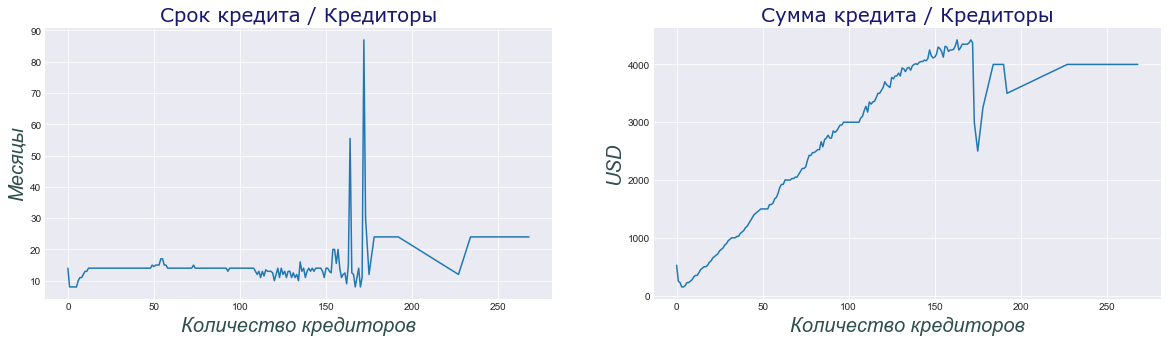

In [193]:
kiva_sort = df_kiva_loans_trimmed.sort_values('lender_count', ascending = True).copy()
kiva_sort = kiva_sort[['loan_amount','term_in_months','lender_count']]
kiva_sort.reset_index(drop=True, inplace=True)
kiva_sort = kiva_sort.groupby('lender_count', as_index=False).median()
kiva_sort.index = kiva_sort['lender_count']
del kiva_sort['lender_count']
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].plot(kiva_sort.index, kiva_sort['term_in_months'])
axes[1].plot(kiva_sort.index, kiva_sort['loan_amount'])
axes[0].set_title('Срок кредита / Кредиторы', fontfamily = 'Verdana', fontsize = 20, color = 'midnightblue', fontstyle = 'normal')
axes[1].set_title('Сумма кредита / Кредиторы', fontfamily = 'Verdana', fontsize = 20, color = 'midnightblue', fontstyle = 'normal')
axes[0].set_xlabel('Количество кредиторов', fontsize = 20, color = 'darkslategrey', fontstyle = 'oblique')
axes[0].set_ylabel('Месяцы', fontsize = 20, color = 'darkslategrey', fontstyle = 'oblique')
axes[1].set_xlabel('Количество кредиторов', fontsize = 20, color = 'darkslategrey', fontstyle = 'oblique')
axes[1].set_ylabel('USD', fontsize = 20, color = 'darkslategrey', fontstyle = 'oblique')
plt.show()

***

- Влияние показателя **MPI** (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.

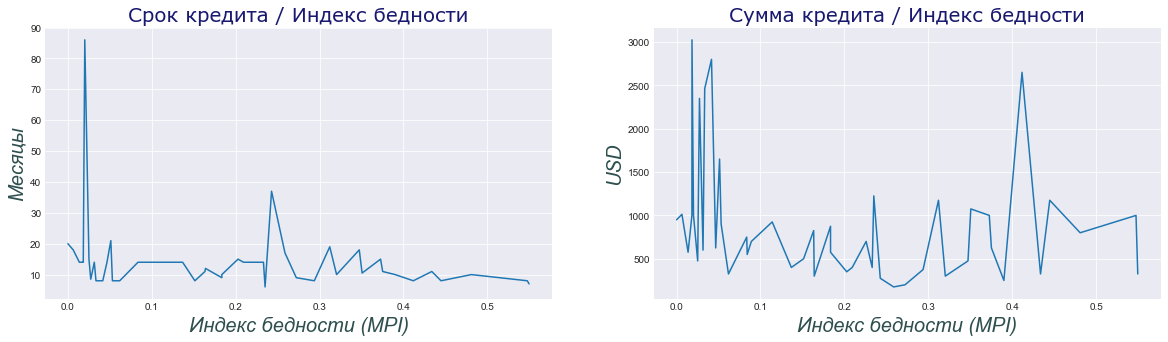

In [194]:
kiva_mpi = df_kiva_loans_trimmed.sort_values('MPI', ascending = True).copy()
kiva_mpi = kiva_mpi.dropna()
kiva_mpi = kiva_mpi[['loan_amount','term_in_months','MPI']]
kiva_mpi.reset_index(drop=True, inplace=True)
kiva_mpi = kiva_mpi.groupby('MPI', as_index=False).median()
kiva_mpi.index = kiva_mpi['MPI']
del kiva_mpi['MPI']
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].plot(kiva_mpi.index, kiva_mpi['term_in_months'])
axes[1].plot(kiva_mpi.index, kiva_mpi['loan_amount'])
axes[0].set_title('Срок кредита / Индекс бедности', fontfamily = 'Verdana', fontsize = 20, color = 'midnightblue', fontstyle = 'normal')
axes[1].set_title('Сумма кредита / Индекс бедности', fontfamily = 'Verdana', fontsize = 20, color = 'midnightblue', fontstyle = 'normal')
axes[0].set_xlabel('Индекс бедности (MPI)', fontsize = 20, color = 'darkslategrey', fontstyle = 'oblique')
axes[0].set_ylabel('Месяцы', fontsize = 20, color = 'darkslategrey', fontstyle = 'oblique')
axes[1].set_xlabel('Индекс бедности (MPI)', fontsize = 20, color = 'darkslategrey', fontstyle = 'oblique')
axes[1].set_ylabel('USD', fontsize = 20, color = 'darkslategrey', fontstyle = 'oblique')
plt.show()

***

- Зависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж», в разрезе **макрорегионов**.

In [195]:
from datetime import datetime
multi_kiva = df_kiva_loans_trimmed[['loan_amount', 'term_in_months', 'disbursed_time', 'posted_time', 'funded_time', 'world_region']].dropna()
multi_kiva_float = multi_kiva.groupby('world_region').agg(['median'])
multi_kiva_float.columns = ['loan_amount','term_in_months']
multi_kiva_float['monthly_pay'] = round(multi_kiva_float['loan_amount'] / multi_kiva_float['term_in_months'],1)

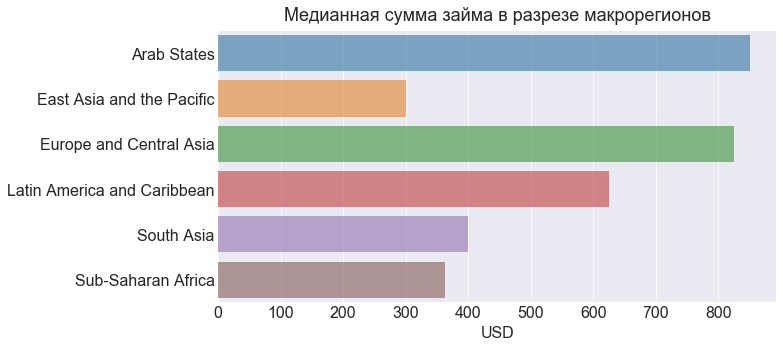

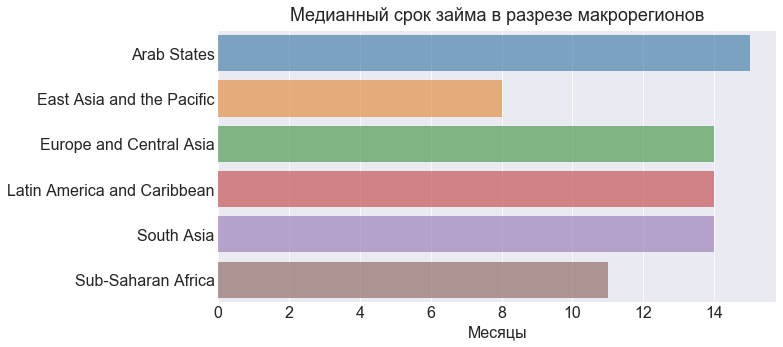

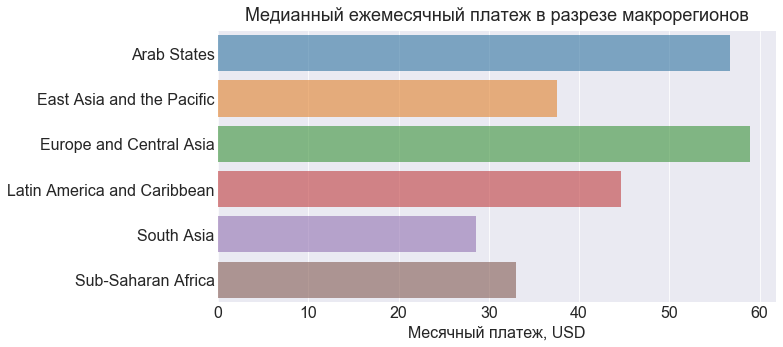

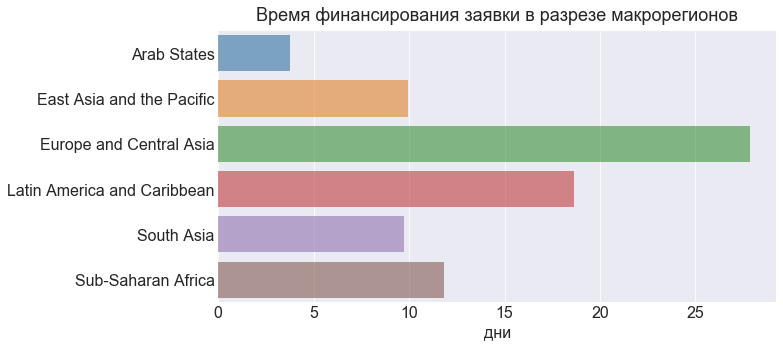

In [205]:
plt.figure(figsize=(10,5))
sns.barplot(y=multi_kiva_float.index, x=multi_kiva_float['loan_amount'].values, alpha=0.6)
plt.title("Медианная сумма займа в разрезе макрорегионов", fontsize=18, pad = 10)
plt.tick_params(labelsize=16)
plt.ylabel('')
plt.xlabel('USD', fontsize=16)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(y=multi_kiva_float.index, x=multi_kiva_float['term_in_months'].values, alpha=0.6)
plt.title("Медианный срок займа в разрезе макрорегионов", fontsize=18, pad = 10)
plt.tick_params(labelsize=16)
plt.ylabel('')
plt.xlabel('Месяцы', fontsize=16)
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(y=multi_kiva_float.index, x=multi_kiva_float['monthly_pay'].values, alpha=0.6)
plt.title("Медианный ежемесячный платеж в разрезе макрорегионов", fontsize=18, pad = 10)
plt.tick_params(labelsize=16)
plt.ylabel('')
plt.xlabel('Месячный платеж, USD', fontsize=16)
plt.show()

multi_kiva_obj = multi_kiva.dropna(subset=['disbursed_time', 'funded_time'], how='any', inplace=False)
dates = ['posted_time','disbursed_time']
multi_kiva_obj[dates] = multi_kiva_obj[dates].applymap(lambda x : x.split('+')[0])
multi_kiva_obj[dates] = multi_kiva_obj[dates].apply(pd.to_datetime)
multi_kiva_obj['time_funding'] = multi_kiva_obj['disbursed_time'] - multi_kiva_obj['posted_time']
multi_kiva_obj['time_funding'] = multi_kiva_obj['time_funding'] / timedelta(days=1)
dev = (multi_kiva_obj['time_funding'] - multi_kiva_obj['time_funding'].mean()).abs()
std = multi_kiva_obj['time_funding'].std()
multi_kiva_obj = multi_kiva_obj[~(dev>3*std) & (multi_kiva_obj.loc[:, 'time_funding']>0)]
multi_kiva_obj = multi_kiva_obj.groupby('world_region').agg(['median'])
multi_kiva_obj.columns = ['loan_amount','term_in_months', 'time_funding']
plt.figure(figsize=(10,5))
sns.barplot(y=multi_kiva_obj.index, x=multi_kiva_obj['time_funding'].values, alpha=0.6)
plt.title("Время финансирования заявки в разрезе макрорегионов", fontsize=18, pad = 10)
plt.tick_params(labelsize=16)
plt.ylabel('')
plt.xlabel('дни', fontsize=16)
plt.show()

### К О Н Е Ц

In [204]:
# тестовые проверки
#list(multi_kiva.groupby('world_region').groups.keys())
#list(df_kiva_loans_trimmed.groupby('borrower_genders').groups.keys())
#df_kiva_loans_trimmed.groupby('world_region')['borrower_genders'].count()
#df_kiva_loans_trimmed.groupby('world_region')['borrower_genders'].nunique()
#df_kiva_loans_trimmed.groupby('world_region')['borrower_genders'].unique()